In [12]:
import numpy as np
import pandas as pd
import cv2
import os
import re
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [13]:
path = './data'
train_df = pd.read_csv(path+'/train.csv')
print(train_df.head())

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1


In [16]:
'''
extract x,y,w,h from bbox
'''
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = re.findall('([0-9]+[.]?[0-9]*)',x)
    if len(r) == 0:
        r = [-1,-1,-1,-1]
    return r

train_df[['x','y','w','h']] = np.stack(train_df['bbox'].apply(expand_bbox))
print(train_df.head())
train_df['x'] = train_df['x'].astype(np.float64)
train_df['y'] = train_df['y'].astype(np.float64)
train_df['w'] = train_df['w'].astype(np.float64)
train_df['h'] = train_df['h'].astype(np.float64)


    image_id  width  height                         bbox   source      x  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1  834.0   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1  226.0   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1  377.0   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1  834.0   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1   26.0   

       y      w      h  
0  222.0   56.0   36.0  
1  548.0  130.0   58.0  
2  504.0   74.0  160.0  
3   95.0  109.0  107.0  
4  144.0  124.0  117.0  


['b6ab77fd7' 'b53afdf5c' '7b72ea0fb' ... 'a5c8d5f5c' 'e6b5e296d'
 '5e0747034']


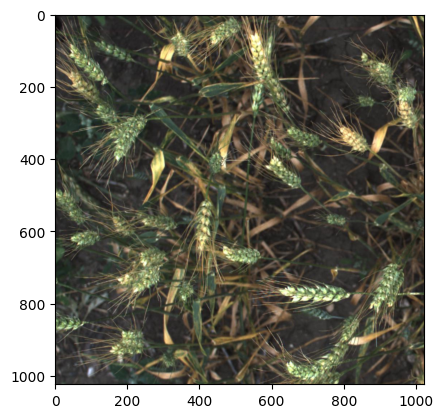

In [19]:
image_ids = train_df['image_id'].unique()
print(image_ids)
image = cv2.imread('./data/train/b6ab77fd7.jpg',cv2.IMREAD_COLOR)  # BGR -> RGB
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float64)
image /= 255.

plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


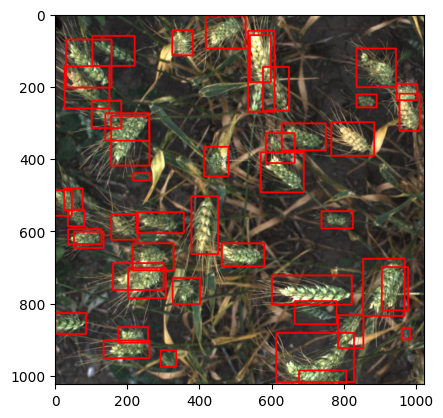

In [20]:
'''
show the image and bbox
'''
records = train_df[train_df['image_id']=='b6ab77fd7'][['x','y','w','h']].values
for box in records:
    x = int(box[0])
    y = int(box[1])
    w = int(box[2])
    h = int(box[3])
    '''
    image
    (x1, y1)
    (x2, y2)
    '''
    cv2.rectangle(image,
                   (x,y),
                   (x+w, y+h),
                   (255,0,0),
                   3)

plt.imshow(image)
plt.show()

In [21]:
"""
目标检测，实例分割
Faster RCNN(selected)
Mask RCNN

torchvision fasterrcnn 模型架构
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html?highlight=fasterrcnn_resnet50_fpn

dataset:
1. image
2. target(dict):
    1) boxes
    2) labels
    3) image_id
    4) area
    5) iscrowd
"""
class WheatDataset(Dataset):
    def __init__(self, dataframe, dir, transforms):
        self.df =dataframe
        self.image_ids = dataframe['image_id'].unique()
        self.dir = dir
        self.transforms = transforms
    def __getitem__(self, item):
        image_ids = self.image_ids[item]
        image = cv2.imread(self.dir+'/'+image_ids+'.jpg',cv2.IMREAD_COLOR)  # BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64)
        image /= 255.
        boxes = self.df[self.df['image_id']==image_ids][['x','y','w','h']].values
        # x,y   w,h  -> (x1, y1) , (x2,y2)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        labels = torch.ones((len(boxes)), dtype=torch.int)
        area = (boxes[:,2] - boxes[:,0])*(boxes[:,3]-boxes[:,1])
        iscrowd = torch.zeros((len(boxes)),dtype=torch.int)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = torch.tensor(area,dtype=torch.float64)
        target['image_id'] = torch.tensor(item,dtype=torch.int)
        target['iscrowd'] = iscrowd
        
        # data augment
        sample = {
            'image':image,
            'bboxes':target['boxes'],
            'labels':target['labels']
        }
        '''
        1. transforms
        2. *arg, **kwargs
        '''
        if self.transforms:
            sample = self.transforms(**sample)
            image = torch.tensor(sample['image'],dtype=torch.float64)
            target['boxes'] = torch.tensor(sample['bboxes'],dtype=torch.float64)
            target['labels'] = torch.tensor(sample['labels'],dtype=torch.int64)

        return image, target
    def __len__(self):
        return len(self.image_ids)

In [ ]:
def get_train_tranforms():
    #随机翻转和变换为tensor
    return A.Compose([
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ],bbox_params={'format':'pascal_voc','label_fields':['labels']})
DIR = './data/train'
dataset = WheatDataset(train_df,DIR,transforms=get_train_tranforms())
tmp = dataset.__getitem__(0)
print(tmp)

In [ ]:
'''
模型定义
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html?highlight=fasterrcnn_resnet50_fpn
pytorch cuda地址: https://download.pytorch.org/whl/cpu/torch_stable.html
pytorch cuda地址：https://download.pytorch.org/whl/cu92/torch_stable.html
torch: 1.6.0
torchvision: 0.7.0
'''
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (wheat) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
print('in_features',in_features)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

def collate_fn(batch):
    return tuple(zip(*batch))
dataset = WheatDataset(train_df, DIR, transforms=get_train_tranforms())
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

param = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(param, lr=0.001)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model.to(device)
EPOCHS = 2
for epoch in range(EPOCHS):
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss = model(images, targets)
        loss = sum(i for i in loss.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())